In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cProfile
from collections import deque, Counter
from time import time

path = '/home/mariano/Descargas/VID_20170720_132629833.mp4'  # Belen
# path = '/home/mariano/Descargas/VID_20170728_112226772.mp4'  # Maxi Hissa


from calculo.video import centroid  # Cython

def center_of_square(contour):
    return centroid(*cv2.boundingRect(contour))

def image_proccess(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    binary = cv2.threshold(gray, 240., 255., cv2.THRESH_BINARY)[1]
    contours= cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
    mark = np.array(map(center_of_square, contours))
    return mark.shape[0], mark


In [2]:

def roi_center(array, amp=1.15):
    y1 = array[0][1]
    y2 = array[-1][1]
    dy = (y1 - y2)*amp
    center = (y1 + y2) / 2
    return(center - dy, center +  dy)  # límite superior, límite inferior

def grouping(markers, n_expected, kroi=False):
    if kroi:
        Y = markers[:, 1]
        G0 = markers[Y < kroi[0]]
        G1 = markers[np.logical_and(Y > kroi[0], Y < kroi[1])]
        G2 = markers[Y > kroi[1]]
    else:
        G0 = markers[5:, :]
        G1 = markers[3:5, :]
        G2 = markers[:3, :]
    n_obtained = (G0.shape[0], G1.shape[0], G2.shape[0])
    boolean_interpolate = [a != b for a, b in zip(n_expected, n_obtained)]
    to_interpolate = [v for v, b in zip((0, 1, 2), boolean_interpolate) if b]
    return(to_interpolate, (G0, G1, G2))

In [3]:
%%time
# En este bloque se abre el video y se procesan las imágenes en busqueda de los
# marcadores.
# Solo se agregan al arreglo de datos(list) los arreglos de marcadores que se 
# delimitan en un intervalo cerrado cuyos extremos(arreglo de marcadores tambien)
# poseen 7 marcadores.
vid = cv2.VideoCapture(path)
is_frame, frame = vid.read()
expected_markers = (2, 2, 3)
M = sum(expected_markers)
safe_None = 25
last_M = 0
active = False
count_non_data = 0
data = []
interp = []
i = 0

while is_frame:
    m, mark = image_proccess(frame)
    if mark.any():
        if m == M:
            active = True
            last_M = i
            count_non_data = 0
        if active:
            if m != M:
                to_interp, groups = grouping(mark, expected_markers, kr)
                data.append(groups)
                interp.append((i, to_interp))
            else:
                __, groups = grouping(mark, expected_markers)
                kr = roi_center(groups[1])
                data.append(groups)
        else:
            data.append(None)
    else:
        count_non_data += 1
        if active and count_non_data < safe_None:
            data.append(mark)
            interp.append(i)
        else:
            if active:
                backwards = i - last_M
                for __ in range(backwards - 1):
                    data.pop()
                    interp.pop()
                data += [None, ]*backwards
                active = False
            else:
                data.append(None)

    is_frame, frame = vid.read()
    i += 1

CPU times: user 2min 19s, sys: 1.54 s, total: 2min 20s
Wall time: 56.5 s


In [4]:
len(data)

4169

In [5]:
#Necesito corregir los marcadores de tobillo.
def diff(array):
    vel = []
    for prev, new in zip(array[:-1], array[1:]):
        if prev and new:
            vel.append((new - prev) != 0)
        else:
            vel.append(None)
    vel.append(None)
    return vel


def get_direction(foot_group):
    if foot_group is None:
        return 0
    x_antepie = foot_group[0, 0]
    x_talon = foot_group[1, 0]
    if x_talon < x_antepie:
        return 1
    else:
        return -1


def sort_foot_markers(foot, direction=False):
    if foot is None or foot.shape[0] != 3:
        return None
    else:
        x1, x2, refer = foot[:, 0]
        if direction:
            if direction > 0:
                if x1 < x2:
                    talon = foot[0]
                    antepie = foot[1]
                else:
                    talon = foot[1]
                    antepie = foot[0]
            elif direction < 0:
                if x1 < x2:
                    talon = foot[1]
                    antepie = foot[0]
                else:
                    talon = foot[0]
                    antepie = foot[1]
        else:
            values = ((abs(refer - x1), 0),
                      (abs(refer - x2), 1))
            talon = foot[min(values)[1]]
            antepie = foot[max(values)[1]]            
    maleolo = foot[-1]
    return np.array((antepie, talon, maleolo))

In [6]:
# Todo revisar codigo completo en busqueda de simplificación.
def set_direction(foot_markers, vel, none_limit=25):
    values = []
    buff = []
    for i, vel in enumerate(vel):
        if vel:
            buff.append((i, 0))
        elif vel is None:
            values.append((i, None))
        else:
            ordered = sort_foot_markers(foot_markers[i])
            direction = get_direction(ordered)
            values.append((i, direction))

    directions = []
    for i, val in values + buff:
        directions.insert(i, val)
    none_values = 0
    rare_indices = []
    dire_indices = []
    dire_values = []
    for i, val in enumerate(directions):
        if val is None:
            if none_values < none_limit:
                rare_indices.append(i)
                none_values += 1
            else:
                if dire_values != []:
                    freq = 1 if sum(dire_values) > 0 else -1
                    for j in dire_indices + rare_indices[:-none_limit]:
                        directions.pop(j)
                        directions.insert(j, freq)
                    dire_values = []
                    dire_indices = []
                    rare_indices = []
        elif val == 0:
            rare_indices.append(i)
            none_values = 0
        else:
            dire_values.append(val)
            dire_indices.append(i)
            none_values = 0
    return directions

In [7]:
foot_group = map(lambda x: x[2] if x is not None else None, data)
y_foot = map(lambda x: x[0, 1] if x is not None else None, foot_group)

In [10]:
vel = diff(y_foot)

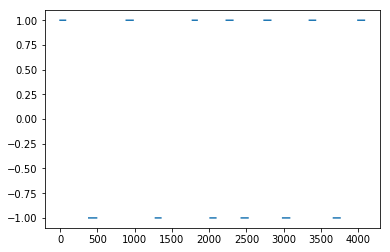

In [13]:
directions = set_direction(foot_group, vel)
plt.plot(directions)
plt.show()

In [14]:
foot_group = map(sort_foot_markers, foot_group, directions)

In [15]:
# TODO: modificar viejo codigo con la lista de los valores a interpolar.
def linear(x, x1, x2, y1, y2):
    num = (x - x1)*(y2 - y1)
    div = (x2 - x1)
    if not div.all():
        return (y2 + y1) / 2
    return num / div + y1

def interpolate(A, B, n_steps):
    n_steps += 1
    x1, y1 = A.T
    x2, y2 = B.T
    dx = (x2 - x1) / n_steps
    interpolated = []
    for n in xrange(1, n_steps):
        X = x1 + dx*n
        Y = linear(X, x1, x2, y1, y2)
        interpolated.append(np.array((X, Y), dtype=int).T)
    return interpolated

def fill_in(array, none_limit=25):
    interpolated = []
    none_indices = []
    none_values = none_limit
    for i, c_arr in enumerate(array):
        if c_arr is None:
            if none_values < none_limit:
                none_indices.append(i)
            else:
                none_indices = []
            none_values += 1
        else:
            if none_indices:
                interp = interpolate(l_arr, c_arr, none_values)
                for par in zip(none_indices, interp):
                    interpolated.append(par)
                none_indices = []
                none_values = 0
            else:
                none_values = 0
            l_arr = c_arr
    for i, arr in interpolated:
        array.pop(i)
        array.insert(i, arr)

In [16]:
fill_in(foot_group)

In [19]:
from time import sleep
array = foot_group

vid = cv2.VideoCapture(path)
n = 0
while True:
    is_frame, frame = vid.read()
    if is_frame is False:
        break
    marker = array[n]
    if marker is not None:
        for arr in marker:
            cv2.circle(frame, (arr[0], arr[1]), 7, (0, 0, 255), -1)
    cv2.imshow(path, cv2.resize(frame, None, fx=.4, fy=.4))
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
    n += 1
    #sleep(.15)
vid.release()
cv2.destroyAllWindows()
# El codigo está funcionando.
# TODO: documentar, y realizar esquemas de lógica de control.